# Module 3 Lab 3 - Longitudinal data and sampling

So far in this and prior modules, when looking at logitudinal data with regressions (GEE and LMM), we have leveraged the entire dataset, because our primary goal was to use modeling to understand the relationships in the data.

However, if you wish to fit a model that is intended to be used as a predictor or classifier, then you need to address how to properly split the dataset into training and testing sets.  For longitudinal data in long form (one row per observation, as opposed to short form which is one row per subject) we cannot just take a simple random sample from the dataset, or we would end up separating the complete set of longitudinal values belonging to a subject into the train and test sets. 

Instead, we need to do block, or group, sampling.  In this short lab you will see how.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data
We are using data sourced from the NHANES data repository.

The documentation for our data file is [here](../resources/bp.txt).


In [2]:
data = pd.read_csv('../resources/bp.csv')

display(data.head(15))

,seq,age,male,bmi,bp_type,bp_seq,bp_value
0,62161,22.0,1,23.3,S,1,110.0
1,62161,22.0,1,23.3,D,2,68.0
2,62161,22.0,1,23.3,S,3,118.0
3,62161,22.0,1,23.3,D,3,74.0
4,62161,22.0,1,23.3,S,2,104.0
5,62161,22.0,1,23.3,D,1,82.0
6,62163,14.0,1,17.3,S,2,108.0
7,62163,14.0,1,17.3,D,3,38.0
8,62163,14.0,1,17.3,S,3,106.0
9,62163,14.0,1,17.3,D,2,36.0


## Block Randomization

Our dataset consists of systolic and diastolic readings taken from a set of subjects.  Each subject had at most three bp readings taken in successive visits, which represent our longitudinal and dependent data. If we took a simpe random sample of 33%, then we would expect that for each subject, we would not select all of their bp readings.  Trying to fit a LMM model on this sample would not be representative of the whole dataset, because we would have eliminated some portion of each subjects' longitudinal data, making the LMM less powerful.

Instead we need to select a random number of subjects, and then get all of the data for those subjects.

For this example we only look at systolic blood pressure.

We will display a histogram of the number of systolic bp counts per subject.

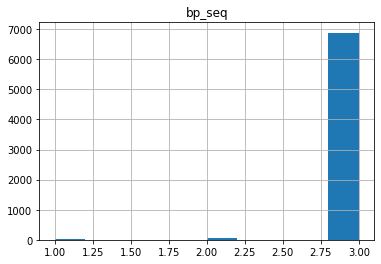

In [3]:
model_data = data.loc[data['bp_type'] == 'S']

model_data.groupby(by='seq')[['bp_seq']].count().hist()
plt.show()



We can see that nearly all of the subjects have 3 observations for systolic bloodpressure, with a few that only had one or two.

Now, we will apply a naive train/test split using the `train_test_split` function from sklearn and observe the results.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f255e022400>]],
      dtype=object)

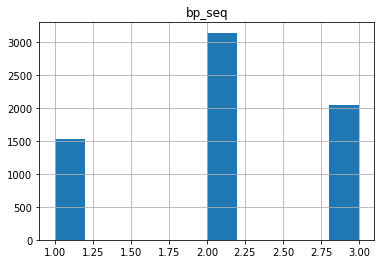

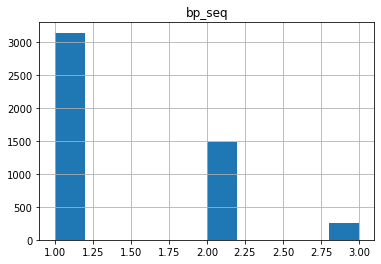

In [4]:
from sklearn.model_selection import train_test_split

y=model_data['bp_value']
X=model_data.drop('bp_value', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.groupby(by='seq')[['bp_seq']].count().hist()
X_test.groupby(by='seq')[['bp_seq']].count().hist()

With the longitudinal-unaware approach, we see that now we have a completely different distribution of counts of bp readings in the train and test sets.  Our longitudinal analysis will now be skewed because a large portion of our training data has fewer than the full number of bp readings available for analysis, and the test data set is not representative of either the train or the full dataset.

For a proper split, the splitting technique must be group aware.  We can do this with some built in split classes from sklearn.

First is a train/test split:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f255df1eb70>]],
      dtype=object)

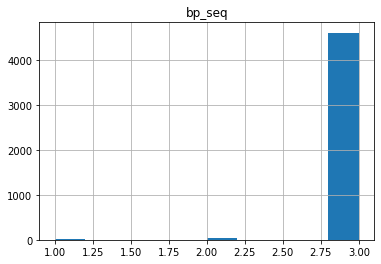

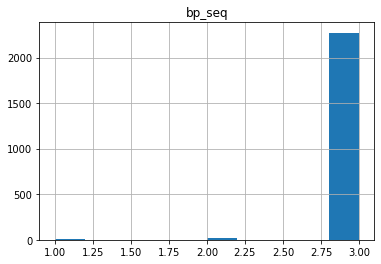

In [5]:
from sklearn.model_selection import GroupShuffleSplit

groups=model_data['seq']

train_indx, test_indx = next(GroupShuffleSplit(n_splits=2, test_size=.33, random_state=42).split(X, y, groups))

X_train, X_test, y_train, y_test = X.iloc[train_indx], X.iloc[test_indx], y.iloc[train_indx], y.iloc[test_indx]

X_train.groupby(by='seq')[['bp_seq']].count().hist()
X_test.groupby(by='seq')[['bp_seq']].count().hist()

Now we can see that the train and test splits retain the distribution of the original data.

k-fold cross validation can also account for grouped data, as below.  We will create a 3 fold cross validation and print the distribution of bp values in the train set created by each fold.

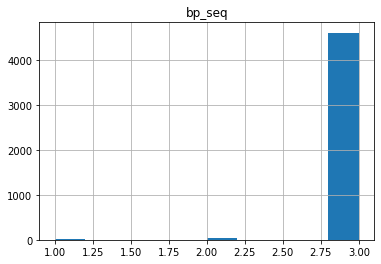

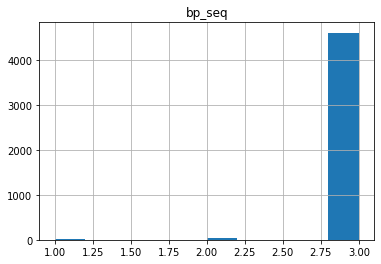

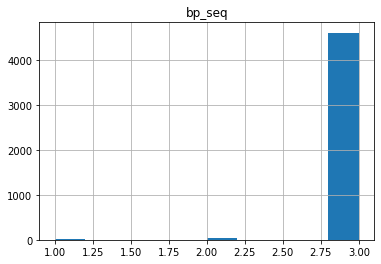

In [6]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3)
for train, test in gkf.split(X, y, groups=groups):
    X_train.groupby(by='seq')[['bp_seq']].count().hist()
    plt.show()

We again see that the distribution is retained.

Finally, we will see how to do a train test split on longitudinal data without using sklearn.  We select a random sample of unique subject identifiers, and use those to get data from our original data frame.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f255dc423c8>]],
      dtype=object)

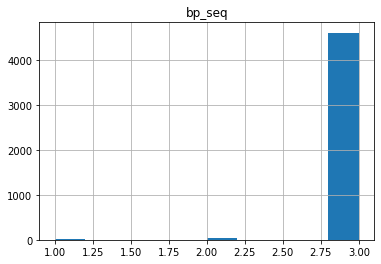

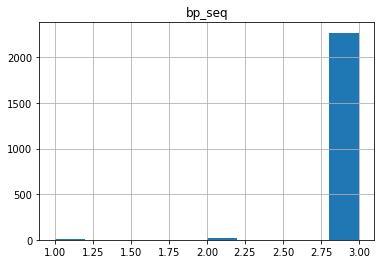

In [7]:
test_seqs = pd.Series(model_data['seq'].unique()).sample(frac=0.33, random_state=42)

train = model_data[~model_data['seq'].isin(test_seqs)]
test = model_data[model_data['seq'].isin(test_seqs)]

train.groupby(by='seq')[['bp_seq']].count().hist()
test.groupby(by='seq')[['bp_seq']].count().hist()